In [52]:
from scipy import io
import spectral
import visdom
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
datasets = {'IndianPines': {
            'urls': ['http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat',
                     'http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat'],
            'img': 'Indian_pines_corrected.mat',
            'gt': 'Indian_pines_gt.mat'
            }}

In [3]:
img = io.loadmat('./Dataset/Indian_pines_corrected.mat')

In [4]:
img = img['indian_pines_corrected']

In [71]:
img[:,:, 43].max()

8817

In [6]:
rgb_bands = (43, 21, 11) # AVIRIS sensor

In [7]:
gt = io.loadmat('./Dataset/Indian_pines_gt.mat')

In [8]:
gt = gt['indian_pines_gt']

In [61]:
gt.shape

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
label_values = ["Undefined", "Alfalfa", "Corn-notill", "Corn-mintill",
                        "Corn", "Grass-pasture", "Grass-trees",
                        "Grass-pasture-mowed", "Hay-windrowed", "Oats",
                        "Soybean-notill", "Soybean-mintill", "Soybean-clean",
                        "Wheat", "Woods", "Buildings-Grass-Trees-Drives",
                        "Stone-Steel-Towers"]

In [11]:
ignored_labels = [0]

Now,

img: Hyperspectral image of 145x145 resolution, with 200 bands

gt: Ground truth labels for each pixel (ranging from 0 to 16)

label_values: If gt value is 3, it belongs to class label label_values[3]

ignored_labels: Pixels that are undefined

rgb_bands: Image channels that belong to R, G and B color band

In [28]:
rgb = spectral.get_rgb(img, rgb_bands) # rgb is in range 0 to 1

In [14]:
# Run visdom server by running 'visdom' in the terminal
viz = visdom.Visdom()

Setting up a new session...


In [29]:
rgb = np.asarray(255 * rgb, dtype='uint8') # to bring it to 0 to 255 and integer values

In [32]:
caption = "RGB (bands {}, {}, {})".format(*rgb_bands)

In [34]:
rgb.shape

(145, 145, 3)

In [39]:
viz.images([np.transpose(rgb, (2, 0, 1))], opts={'caption':caption})
# Transpose is used and not reshape because transpose keeps the data
# relativity intact, while reshape doesnt

'window_3849be8169c590'

In [43]:
palette = {0: (0, 0, 0)}
for k, color in enumerate(sns.color_palette("hls", 16)):
    palette[k + 1] = tuple(np.asarray(255 * np.array(color), dtype='uint8'))

In [45]:
palette

{0: (0, 0, 0),
 1: (219, 94, 86),
 2: (219, 144, 86),
 3: (219, 194, 86),
 4: (194, 219, 86),
 5: (145, 219, 86),
 6: (95, 219, 86),
 7: (86, 219, 127),
 8: (86, 219, 177),
 9: (86, 211, 219),
 10: (86, 161, 219),
 11: (86, 111, 219),
 12: (111, 86, 219),
 13: (160, 86, 219),
 14: (210, 86, 219),
 15: (219, 86, 178),
 16: (219, 86, 128)}

In [46]:
# converting 145x145 labels into a color coded image
arr_3d = np.zeros((*gt.shape, 3), dtype='uint8')
for c,i in palette.items():
    m = gt == c
    arr_3d[m] = i

In [53]:
def explore_spectrums(img, complete_gt, class_names, vis,
                      ignored_labels=None):
    """Plot sampled spectrums with mean + std for each class.
    Args:
        img: 3D hyperspectral image
        complete_gt: 2D array of labels
        class_names: list of class names
        ignored_labels (optional): list of labels to ignore
        vis : Visdom display
    Returns:
        mean_spectrums: dict of mean spectrum by class
    """
    mean_spectrums = {}
    for c in np.unique(complete_gt):
        if c in ignored_labels:
            continue
        mask = complete_gt == c
        class_spectrums = img[mask].reshape(-1, img.shape[-1])
        step = max(1, class_spectrums.shape[0] // 100)
        fig = plt.figure()
        plt.title(class_names[c])
        # Sample and plot spectrums from the selected class
        for spectrum in class_spectrums[::step, :]:
            plt.plot(spectrum, alpha=0.25)
        mean_spectrum = np.mean(class_spectrums, axis=0)
        std_spectrum = np.std(class_spectrums, axis=0)
        lower_spectrum = np.maximum(0, mean_spectrum - std_spectrum)
        higher_spectrum = mean_spectrum + std_spectrum

        # Plot the mean spectrum with thickness based on std
        plt.fill_between(range(len(mean_spectrum)), lower_spectrum,
                         higher_spectrum, color="#3F5D7D")
        plt.plot(mean_spectrum, alpha=1, color="#FFFFFF", lw=2)
        vis.matplot(plt)
        mean_spectrums[class_names[c]] = mean_spectrum
    return mean_spectrums

In [54]:
def plot_spectrums(spectrums, vis, title=""):
    """Plot the specified dictionary of spectrums.
    Args:
        spectrums: dictionary (name -> spectrum) of spectrums to plot
        vis: Visdom display
    """
    win = None
    for k, v in spectrums.items():
        n_bands = len(v)
        update = None if win is None else 'append'
        win = vis.line(X=np.arange(n_bands), Y=v, name=k, win=win, update=update,
                       opts={'title': title})

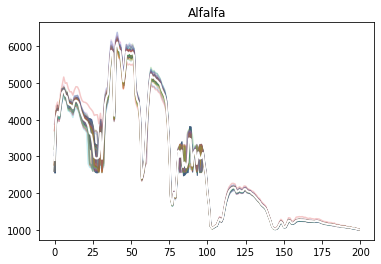

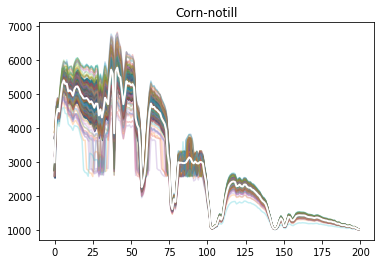

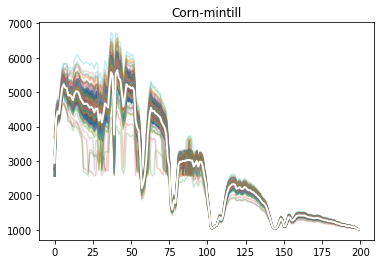

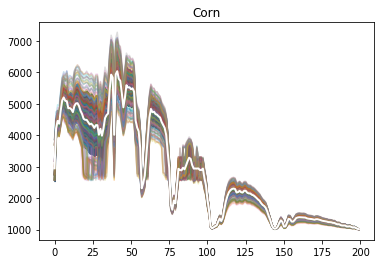

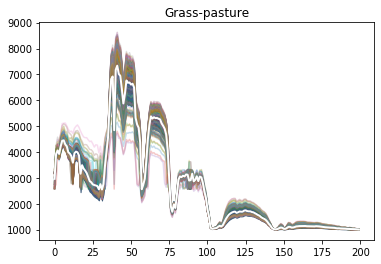

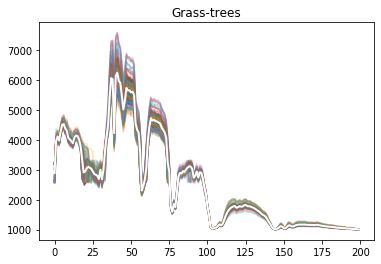

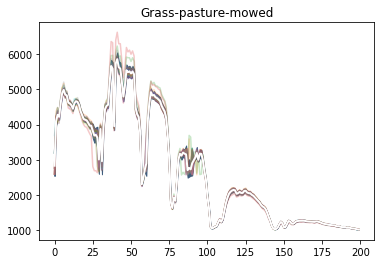

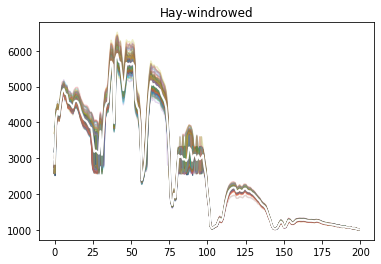

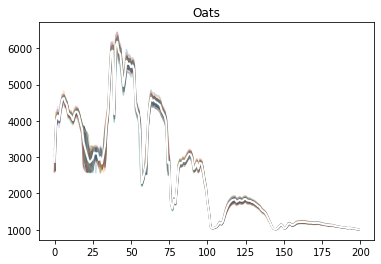

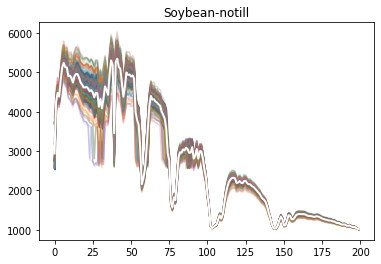

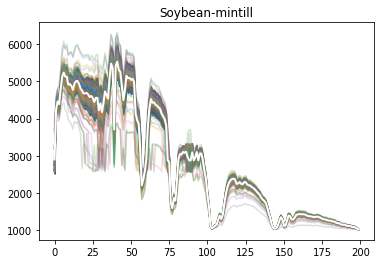

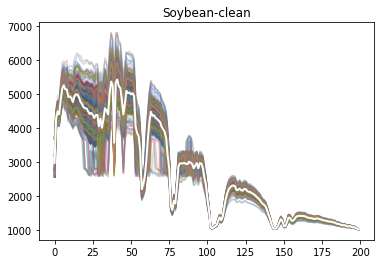

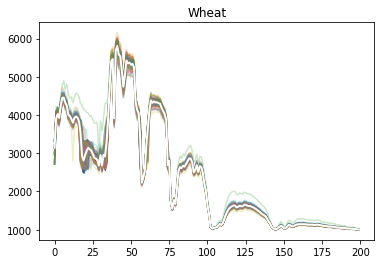

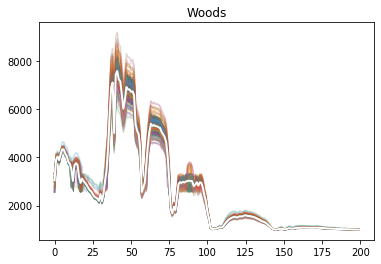

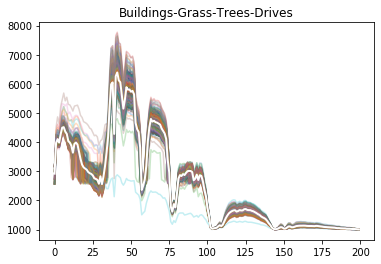

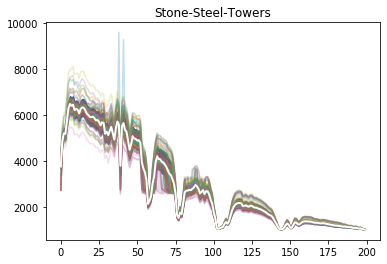

In [55]:
mean_spectrums = explore_spectrums(img, gt, label_values, viz,
                                       ignored_labels=ignored_labels)
plot_spectrums(mean_spectrums, viz, title='Mean spectrum/class')

In [56]:
# Final regular data handling
X = img
y = gt

In [59]:
X.shape, y.shape

((145, 145, 200), (145, 145))

In [60]:
X.reshape(21025, 200), y.reshape(21025,)

(array([[3172, 4142, 4506, ..., 1057, 1020, 1020],
        [2580, 4266, 4502, ..., 1064, 1029, 1020],
        [3687, 4266, 4421, ..., 1061, 1030, 1016],
        ...,
        [3153, 3864, 4282, ..., 1003, 1008, 1000],
        [3155, 4104, 4106, ..., 1011, 1005, 1003],
        [3323, 3860, 4197, ..., 1007, 1004, 1000]], dtype=uint16),
 array([3, 3, 3, ..., 0, 0, 0], dtype=uint8))

In [72]:
# I'm leaving this here because its too complicated and i found better more simpler
# implementations with better results